# Sincronizacion completa

## Definiciones

In [160]:
import matplotlib.pyplot as plt
import math, statistics
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline

In [73]:
#Constantes
eta = 0.001
sigma = -1.6
vs = -1.4
k=50
titas = -1.4
e=0.5
gc = 1.0

#Functions
def f(x, y):
    global alpha
    return alpha/(1 + x**2) + y

def gamma(x):
    global k, titas
    return 1/(1 + math.exp(-1*k*(x-titas)))

def next_x1(x1, y1, x2, y2): 
    global gc, vs, e
    return f(x1, y1) + gc*(vs-x1)*gamma(x2) + e*(f(x2,y2)-f(x1,y1))

def next_y1(x1, y1):
    global eta, sigma
    return y1 - eta*(x1-sigma)

def next_x2(x1, y1, x2, y2):
    return next_x1(x2, y2, x1, y1)

def next_y2(x2, y2):
    return next_y1(x2, y2)

def initialize(a):
    global alpha, x1, x2, y1, y2, r1, r2
    alpha = a
    x1 = -1.6
    x2 = -1.6
    y1 = -2.58
    y2 = -2.58
    r1 = []
    r2 = []

def update():
    global x1, x2, y1, y2
    nx1 = next_x1(x1, y1, x2, y2)
    nx2 = next_x2(x1, y1, x2, y2)
    ny1 = next_y1(x1, y1)
    ny2 = next_y2(x2, y2)
    x1 = nx1
    x2 = nx2
    y1 = ny1
    y2 = ny2

def observe():
    global r1, r2
    r1.append([x1, y1])
    r2.append([x2, y2])

## Ejemplo Sincronizacion completa en diferentes estados

In [89]:
def sim_gc_e(axes, titles=False):
    steps = int(1e5)
    output = 10000
    initialize(4.1)
    for t in range(steps):
        update()
        if(t >= steps - output):
            observe()
    ax = axes[0]
    ax.plot(list(range(steps-output, steps)), [r[0] for r in r1], ',r', alpha=1, label='x1')
    ax.plot(list(range(steps-output, steps)), [r[0] for r in r2], ',b', alpha=.3, label='x2')
    ax.set_xlim(96000, 100000)
    if titles:
        ax.set_title("Serie de Tiempo")
        ax.set_xlabel('steps')
        ax.legend(loc='upper right')
        ax.set_ylabel('X1,2')

    ax = axes[1]
    ax.plot([r[0] for r in r1], [r[1] for r in r1], ',b', alpha=1)
    if titles:
        ax.set_title("Espacio de fases")
        ax.set_xlabel('x1')
        ax.set_ylabel('y1')

    ax = axes[2]
    ax.plot([r[0] for r in r1], [r[0] for r in r2], ',g', alpha=1)
    if titles:
        ax.set_title("Sync Manifold")
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')

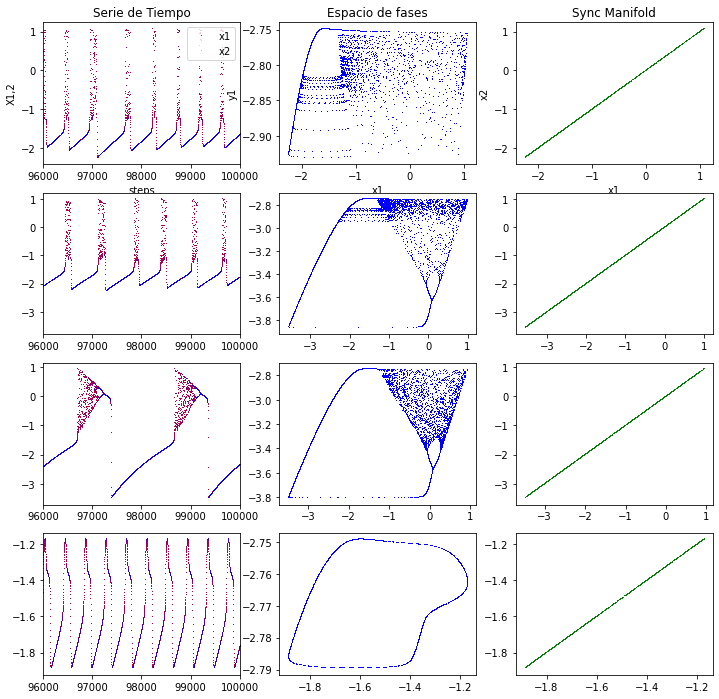

In [75]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=False, sharey=False)

gc = 0.2
e = gc
sim_gc_e(axes[0], titles=True)

gc = 0.25
e = gc
sim_gc_e(axes[1])

gc = 0.3
e = gc
sim_gc_e(axes[2])

gc = 0.6
e = 0.4
sim_gc_e(axes[3])

## Analisis de estabilidad local

In [108]:
def initialize(a, calc_err=False):
    global alpha, x1, x2, y1, y2, r1, r2, error
    alpha = a
    x1 = -1.6
    x2 = x1*0.99
    y1 = -2.58
    y2 = y1*0.99
    r1 = []
    r2 = []
    if calc_err:
        error = []
    
def update(calc_err=False):
    global x1, x2, y1, y2, error
    nx1 = next_x1(x1, y1, x2, y2)
    nx2 = next_x2(x1, y1, x2, y2)
    ny1 = next_y1(x1, y1)
    ny2 = next_y2(x2, y2)
    x1 = nx1
    x2 = nx2
    y1 = ny1
    y2 = ny2
    if calc_err:
        error.append(math.sqrt((x1-x2)**2 + (y1-y2)**2))
    
def observe():
    global r1, r2
    r1.append([x1, y1])
    r2.append([x2, y2])

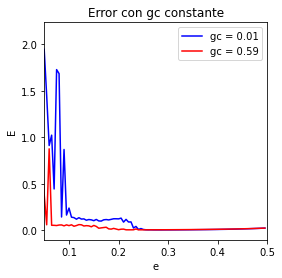

In [142]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharex=False, sharey=False)
axes.set_xlim(0.05, 0.5)
axes.set_xlabel('e')
axes.set_ylabel('E')
axes.set_title('Error con gc constante')

steps = int(1e4)
gc = 0.01
e = 0.1
errors = []
e_range = np.arange(0.,0.5,0.005)
for e in e_range:
    initialize(4.1, calc_err=True)
    for t in range(steps):
            update(calc_err=True)
    errors.append(statistics.mean(error))
    
axes.plot(e_range,errors, 'b', label='gc = 0.01')

errors = []
gc = 0.59
e_range = np.arange(0.,0.5,0.005)
for e in e_range:
    initialize(4.1, calc_err=True)
    for t in range(steps):
            update(calc_err=True)
    errors.append(statistics.mean(error))
    
axes.plot(e_range,errors, 'r', label='gc = 0.59')
axes.legend(loc='upper right')

CPU times: user 7h 44min 5s, sys: 56.2 s, total: 7h 45min 1s
Wall time: 7h 45min 11s


Text(33.0, 0.5, 'gc')

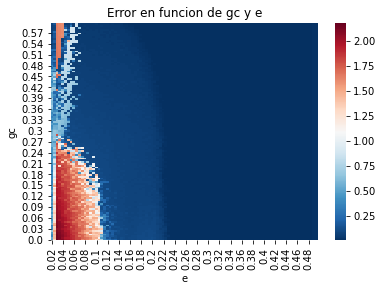

In [185]:
%%time

steps = int(1e5)
gc_list = np.arange(0.,0.6,0.005)
e_list = np.arange(0.02,0.5,0.005)
errors = np.zeros((len(gc_list), len(e_list)))

for idx_e, e in enumerate(e_list):
    for idx_gc, gc in enumerate(gc_list):
        initialize(4.1, calc_err=True)
        for t in range(steps):
                update(calc_err=True)
        errors[idx_gc][idx_e] = statistics.mean(error)

pderrors = pd.DataFrame(data=errors, index=[round(x,2) for x in gc_list], columns=[round(x,2) for x in e_list])
axes = sn.heatmap(data=pderrors, cmap= 'RdBu_r')
axes.invert_yaxis()
axes.set_title("Error en funcion de gc y e")
axes.set_xlabel("e")
axes.set_ylabel("gc")

# Analisis de estabilidad global

*A partir de aca uso pandas + numpy porque el tiempo de procesamiento se dispara*

In [280]:
def initialize():
    global alpha, x1, x2, y1, y2, r1, r2, error
    alpha = 4.1
    x1 = np.random.uniform(-2.5, 1.5)
    x2 = x1*0.99
    y1 = np.random.uniform(-3., -2.)
    y2 = x2*0.99
    r1 = []
    r2 = []
    error = []
    
def update():
    global x1, x2, y1, y2, error
    nx1 = next_x1(x1, y1, x2, y2)
    nx2 = next_x2(x1, y1, x2, y2)
    ny1 = next_y1(x1, y1)
    ny2 = next_y2(x2, y2)
    x1 = nx1
    x2 = nx2
    y1 = ny1
    y2 = ny2
    error.append(math.sqrt((x1-x2)**2 + (y1-y2)**2))
    
def observe():
    global r1, r2
    r1.append([x1, y1])
    r2.append([x2, y2])


In [296]:
gc_list = np.arange(0.,0.6,0.1)
e_list = np.arange(0.02,0.5,0.01)

steps = int(1e5)
T = 1000

In [282]:
basin_stab.count()

e        288
error    288
gc       288
dtype: int64

In [283]:
e_d = pd.DataFrame({"e": pd.Series(e_list), 'error': 0.})
gc_d = pd.DataFrame({"gc": pd.Series(gc_list), 'error': 0.})
basin_stab = pd.merge(e_d, gc_d)

In [284]:
basin_stab.shape

(288, 3)

In [298]:
def sim(x): 
    m = 0
    for i in range(0,T):
        initialize()
        e = x['e']
        gc = x['gc']
        for t in range(steps):
            update()
        if statistics.mean(error) < 0.3: 
            m += 1
    return m/T
        

In [ ]:
%%time

#test = pd.DataFrame({"e": [0.3, 0.5], 'gc':[0.2,0.5], 'err':[0,0]})
#test['err'] = test.apply(sim, axis='columns')
basin_stab['error'] = basin_stab.apply(sim, axis='columns')

In [ ]:

axes = sn.heatmap(data=basin_stab.pivot_table(index='gc', columns='e'), cmap= 'RdBu_r')